# A Gentle Introduction to Forecasting in Merlion

We begin by importing Merlion's `TimeSeries` class and the data loader for the `M4` dataset. We can then divide a specific time series from this dataset into training and testing splits.

In [1]:
from merlion.utils import TimeSeries
from ts_datasets.forecast import M4

time_series, metadata = M4(subset="Hourly")[0]
train_data = TimeSeries.from_pd(time_series[metadata.trainval])
test_data = TimeSeries.from_pd(time_series[~metadata.trainval])

100%|██████████| 414/414 [00:00<00:00, 647.97it/s]


We can then initialize and train Merlion's `DefaultForecaster`, which is an forecasting model that balances performance with efficiency. We also obtain its predictions on the test split.

In [2]:
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster
model = DefaultForecaster(DefaultForecasterConfig())
model.train(train_data=train_data)
test_pred, test_err = model.forecast(time_stamps=test_data.time_stamps)

Next, we visualize the model's predictions.

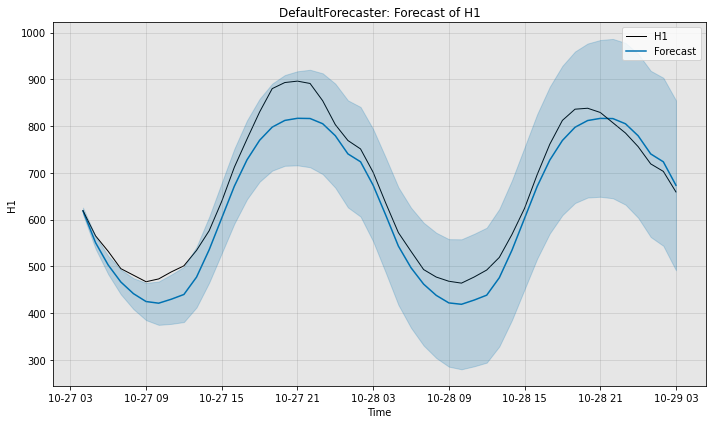

In [3]:
import matplotlib.pyplot as plt
fig, ax = model.plot_forecast(time_series=test_data, plot_forecast_uncertainty=True)
plt.show()

Finally, we quantitatively evaluate the model. sMAPE measures the error of the prediction on a scale of 0 to 100 (lower is better), while MSIS evaluates the quality of the 95% confidence band on a scale of 0 to 100 (lower is better).

In [4]:
from scipy.stats import norm
from merlion.evaluate.forecast import ForecastMetric

# Compute the sMAPE of the predictions (0 to 100, smaller is better)
smape = ForecastMetric.sMAPE.value(ground_truth=test_data, predict=test_pred)

# Compute the MSIS of the model's 95% confidence interval (0 to 100, smaller is better)
lb = TimeSeries.from_pd(test_pred.to_pd() + norm.ppf(0.025) * test_err.to_pd().values)
ub = TimeSeries.from_pd(test_pred.to_pd() + norm.ppf(0.975) * test_err.to_pd().values)
msis = ForecastMetric.MSIS.value(ground_truth=test_data, predict=test_pred,
                                 insample=train_data, lb=lb, ub=ub)
print(f"sMAPE: {smape:.4f}, MSIS: {msis:.4f}")


sMAPE: 6.2855, MSIS: 19.1584
